In [22]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

# Calculate Ocean Surface Albedo v1.0
This is  notebook for calculating ocean surface albedo (OSA) using the approach described in [Roland Seferian et al. 2018](https://www.geosci-model-dev.net/11/321/2018/gmd-11-321-2018.pdf). This improved albedo scheme for the ocean accounts for surface roughness due to wind and waves (whitecap), chlorophyll, backscattering from particles, and estimates both the direct and diffuse components of the albedo.

## Theoretical Fresnel reflection for two mediums
The reflection of incoming solar radiation to a new medium is determined by the refractive indices of the two mediums and the angle of the light. For air and water these indices are 1.0 and 1.34 while the angle is the zenith angle. The following theretical example uses a plane surface between the air and water.

In [23]:
# https://en.wikipedia.org/wiki/Fresnel_equations
# https://computergraphics.stackexchange.com/questions/5182/fresnel-equation-with-incident-angle-n-and-k-as-input
# http://www.oceanopticsbook.info/view/surfaces/the_level_sea_surface#fig:ReflTrans
def fresnel(n,theta_deg,k):
    theta = math.radians(theta_deg)

    a = math.sqrt((math.sqrt((n**2-k**2-(math.sin(theta))**2)**2 +
                                 ((4 * n**2) * k**2)) + (n**2 - k**2 -
                                            (math.sin(theta))**2))/2)

    b = math.sqrt((math.sqrt((n**2-k**2-(math.sin(theta))**2)**2 +
                                 ((4 * n**2) * k**2)) - (n**2 - k**2 -
                                            (math.sin(theta))**2))/2)

    Fs = (a**2+b**2-(2 * a * math.cos(theta))+
              (math.cos(theta))**2)/(a**2+b**2 +
                            (2 * a * math.cos(theta))+(math.cos(theta))**2)

    Fp = Fs * ((a**2+b**2 -
                    (2 * a * math.sin(theta) * math.tan(theta)) +
                    (math.sin(theta))**2*(math.tan(theta))**2)/(a**2+b**2 +
                    (2 * a * math.sin(theta) * math.tan(theta)) +
                    (math.sin(theta))**2*(math.tan(theta))**2))

    R = (Fs + Fp)/2.
    return R

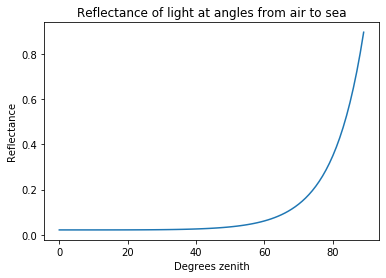

In [24]:
n_air=1.0
n_water=1.34

reflections=[]
degrees=[]
for theta_deg in range(0,90,1):
    reflections.append(fresnel(n_water/n_air,theta_deg,0))
    degrees.append(theta_deg)

plt.plot(degrees, reflections)
plt.title("Reflectance of light at angles from air to sea")
plt.ylabel("Reflectance")
plt.xlabel("Degrees zenith")
plt.show()

### More realistic reflections using OSA
Accounting for the sea surface roughness is done by parameterization of the roughness from the windspeed (whitecap function), while reflection and absorption from chlorophyll and particles is done once for the water column.

In [25]:
# Following Roland Seferian, equation 3
# https://www.geosci-model-dev.net/11/321/2018/gmd-11-321-2018.pdf

def calculate_alpha_dir(n_lambda,µ):
    a = np.sqrt(1.0 - (1.0 - µ**2)/n_lambda**2)
    b = ((a-n_lambda*µ)/(a+n_lambda*µ))**2    
    c = ((µ-n_lambda*a)/(µ+n_lambda*a))**2

    return 0.5*(b+c)

In [26]:
def surface_roughness(µ, σ):
    # Surface roughness following Jin et al. 2014 equation 4
    # This rougness parameter determines the Fresnel refraction 
    # index from flat surface
    return (0.0152-1.7873*µ + 6.8972*(µ**2)-8.5778*(µ**3)+ 4.071*σ-7.6446*µ*σ) * np.exp(0.1643-7.8409*µ-3.5639*µ**2-2.3588*σ+10.054*µ*σ)

In [27]:
def calculate_diffuse_reflection(n_λ,σ):
    # Diffuse albedo from Jin et al., 2006 (Eq 5b) 
    return -0.1479 + 0.1502*n_λ-0.0176*n_λ*σ

In [28]:
def calculate_direct_reflection(n_λ,µ,σ):
    f_0 = calculate_alpha_dir(1.34,µ)
    f_λ = calculate_alpha_dir(n_λ,µ)
    
    return f_λ - (surface_roughness(µ, σ)*f_λ/f_0)

In [29]:
def calculate_direct_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, µ, alpha_direct):
   
    rw=0.48168549-0.014894708*σ-0.20703885*σ**2
 
    # Determine absorption and backscattering
    # coefficients to determine reflectance below the surface (Ro) once for all
    a_bp = 0.06*alpha_chl*chl**0.65 + 0.2*(0.00635+0.06*(chl**0.65))*np.exp(0.014*(440.-λ))
   
    # Backscattering of biological pigment (b_chl) with λ expressed here in nm and [Chl] in mg m−3. This
    # formulation is valid for [Chl] ranging between 0.02 and 2 mg m−3 (Morel and Maritorena (2001))
    # Equation 12 Roland Seferian, 2018
    b_chl=(0.416*chl**0.766)*(0.002+0.01*(0.5-0.25*np.log(chl))*(λ/550.0)**(0.5*(np.log(chl)-0.3)))
   
    # # Use Morel 91 formula to compute the direct reflectance below the surface (Morel-Gentili(1991), Eq (12))
    n=0.5*beta_w/(0.5*beta_w + b_chl)
   
    # Equation 11 Roland Seferian, 2018
    beta = 0.6279-0.2227*n-0.0513*n**2 +(0.2465*n - 0.3119)*µ
    
    # Equation 10 Roland Seferian, 2018
    R0 = beta * (0.5*beta_w + b_chl)/(alpha_w + a_bp)
   
    # Water leaving albedo, equation 8 Roland Seferian, 2018
    return (((1.0-rw)*R0)/(1-rw*R0))*(1-alpha_direct)

In [30]:
def calculate_diffuse_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, alpha_direct):
    #  In the case of ocean interior reflectance for direct incoming radiation it depends on µ = cos(θ) whereas in the
    # case of ocean interior reflectance for diffuse µ = 0.676. This value is considered an effective angle of incoming radiation of 47.47◦
    # according to Morel and Gentili (1991). 
    return calculate_direct_reflection_from_chl(λ, chl, alpha_chl, alpha_w, beta_w, σ, np.arccos(0.676), alpha_direct)

In [31]:
def whitecap():
    # Whitecap effect as defined by Salisbury et al. 2014. NOTE that the value in paper is in percent
    # so we use the ratio instead (/100.) 
    # Salisbury, D. J., Anguelova, M. D., and Brooks, I. M.: Global Distribution and Seasonal 
    # Dependence of Satellite-based Whitecap Fraction
    #
    # Whitecaps are the surface manifestation of bubble plumes, created when 
    # surface gravity waves break and entrain air into the water column. 
    # They enhance air-sea exchange, introducing physical processes different from 
    # those operating at the bubble-free water surface. 

    return 0.000397*(np.exp(1.59*np.log(wind)))

In [1]:
def calculate_spectral_and_broadband_OSA(wind,alpha_wc,alpha_direct,alpha_diffuse,alpha_direct_chl,alpha_diffuse_chl,solar_energy):
    # Calculate the wavelength integrated ocean surface albedo - OSA
    
    wc = whitecap()
    
    OSA_direct = (alpha_direct + alpha_direct_chl) * (1-wc) + wc*alpha_wc
    OSA_diffuse = (alpha_diffuse + alpha_diffuse_chl) * (1-wc) + wc*alpha_wc
    print("OSA_direct {}".format(np.mean(OSA_direct)))

    # Integrate across all wavelengths 200-4000nm at 10 nm wavelength bands and then 
    # weight by the solar energy at each band
    OSA_direct_broadband = np.sum(OSA_direct*solar_energy)
    OSA_diffuse_broadband = np.sum(OSA_diffuse*solar_energy)
    print(OSA_direct_broadband,OSA_diffuse_broadband)

### Sequential calculation of OSA
The sequential steps below performs the required steps to calculate diffuse and direct components of ocean surface albedo using the methods outlined above. All claculations are vectorized using `np.vectorize`.

In [39]:
df=pd.read_csv("data/Wavelength/Fresnels_refraction.csv", header=0, sep=";", decimal=",")
print(df.head())
wavelengths=df["λ"].values
refractive_indexes=df["n(λ)"].values
alpha_chl=df["a_chl(λ)"].values
alpha_w=df["a_w(λ)"].values
beta_w=df["b_w(λ)"].values
alpha_wc=df["a_wc(λ)"].values
solar_energy=df["E(λ)"].values

theta_deg=11.0
wind=10.0
chl=1.00001

# Solar zenith angle
µ = np.cos(np.radians(theta_deg))

# wind is wind at 10 m height (m/s)
σ = np.sqrt(0.003+0.00512*wind)

# Vectorize the functions
vec_calculate_direct_reflection=np.vectorize(calculate_direct_reflection)
vec_calculate_diffuse_reflection=np.vectorize(calculate_diffuse_reflection)
vec_calculate_direct_reflection_from_chl=np.vectorize(calculate_direct_reflection_from_chl)
vec_calculate_diffuse_reflection_from_chl=np.vectorize(calculate_diffuse_reflection_from_chl)

# Direct reflection
alpha_direct = vec_calculate_direct_reflection(refractive_indexes,µ,σ)
print("alpha_direct {}".format(np.mean(alpha_direct)))

# Diffuse reflection
alpha_diffuse = vec_calculate_diffuse_reflection(refractive_indexes,σ)

# Reflectrion from chlorophyll and biological pigments
alpha_direct_chl = vec_calculate_direct_reflection_from_chl(wavelengths, chl, alpha_chl, alpha_w, beta_w, σ, µ, alpha_direct)
print("alpha_direct_chl {}".format(np.mean(alpha_direct_chl)))

# Diffuse reflection interior of water from chlorophyll
alpha_diffuse_chl = vec_calculate_diffuse_reflection_from_chl(wavelengths, chl, alpha_chl, alpha_w, beta_w, σ, alpha_direct)

# OSA
calculate_spectral_and_broadband_OSA(wind,alpha_wc,alpha_direct,alpha_diffuse,alpha_direct_chl,alpha_diffuse_chl,solar_energy)

       λ      E(λ)  n(λ)  a_chl(λ)  a_w(λ)  b_w(λ)  a_wc(λ)
0  200.0  0.000054  1.45     0.775   3.070  0.1510      0.0
1  210.0  0.000206  1.44     0.752   1.990  0.1190      0.0
2  220.0  0.000349  1.42     0.730   1.310  0.0995      0.0
3  230.0  0.000384  1.41     0.708   0.928  0.0820      0.0
4  240.0  0.000292  1.40     0.685   0.718  0.0685      0.0
alpha_direct 0.019962535091639328
alpha_direct_chl 0.0011377583493678476
OSA_direct 0.02191732212765062
0.027057211124531782 0.05294671116125624


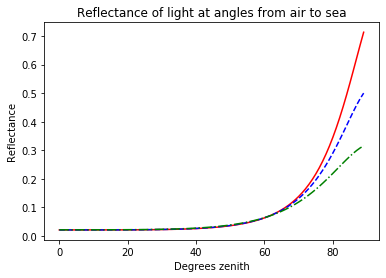

In [35]:
def create_figure2_Jin():
    n_air=1.0
    n_water=1.34
    winds=[0.0,3.0,12.0]
    
    colors=["red","blue","green"]
    styles=['solid', 'dashed', 'dashdot']
    for ind,wind in enumerate(winds):
        reflections=[]; degrees=[]
        σ = np.sqrt(0.003+0.00512*wind)
        for theta_deg in range(0,90,1):
            µ = np.cos(np.radians(theta_deg))
            reflections.append(calculate_direct_reflection(n_water/n_air,µ,σ))
            degrees.append(theta_deg)

        plt.plot(degrees, reflections, color=colors[ind],linestyle=styles[ind])
    plt.title("Reflectance of light at angles from air to sea")
    plt.ylabel("Reflectance")
    plt.xlabel("Degrees zenith")
  #  plt.yscale("log")
    plt.show()
    
create_figure2_Jin()